# Deliverable 7.1 - Nonlinear MPC
**Objective**: A nonlinear MPC controller is implemented for the same landing task of part 6, namely drive the rocket from x=3m, y=2m, z=10m and roll=30° to x=1m, y=0m, z=3m, roll=0°.

**System**:
* State: complete 12-dimensinal state $\rightarrow$ $[\omega_x, \omega_y, \omega_z, \alpha, \beta, \gamma, v_x, v_y, v_z, x, y, z]$
* Input: complete 4-dimensional input $\rightarrow$ $[\delta_1, \delta_2, P_{avg}, P_{diff}]$
* Hard constraint: $z \ge 0$

## 1. Setup and Imports

In [1]:
%load_ext autoreload
%autoreload 2

# Get parent root directory and add to sys.path
import sys, os
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget

from src.rocket import Rocket # rocket_euler
from src.pos_rocket_vis import *
from LandMPC_template.nmpc_land_Claude import NmpcCtrl
import numpy as np

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir,"rocket.yaml")

## 2. NMPC
### Controller Structure
The nonlinear dynamics are integrated inside the optimization using a fourth-order Runge-Kutta (RK4) scheme to ensure accurate state propagation without excessive computational burden.

### Cost Function Design
The NMPC objective consists ofa quadratic stage cost and quadratic terminal cost:
$$
J = \sum_{k=0}^{N-1} [(x_k - x_s)^T Q (x_k -x_s) + (u_k -u_s)^T R(u_k-u_s)]+(x_N-x_s)^TP(x_N-x_s)
$$

#### Stage cost - state weighting Q
$$
Q = diag(10, 10, 10, 100, 100, 20, 20, 20, 100, 200, 200, 200)
$$
* Angular velocities $\omega$: moderate penalty
* Euler angles: high penalty
* Linear velocities: medium penalty
* positions: very high penalty

This tuning reflects the landing objective: **accurate position tracking and upright attitude** are prioritized over transient velocity errors.

#### Stage cost - input weighting R
$$
R = diag(1,1,0.1,1)
$$
* Thrust vector deflections: moderate penalty
* Average throttle: low penalty
* Throttle difference: moderate penalty

The low penalty on $P_{avg} allows the controller to react aggressively in altituda, which is critical for fast and sage landing.

### Terminal Cost Design
To compensate for limited prediction horizon, a terminal cost is introduced.
#### Terminal Cost Computation
The terminal cost matrix $P$ is obtained by
1. Linearizing the nonlinear model around the steady-state target $(x_s,u_s)$
2. Discretizing the linearized dynamics
3. solving a continuous-time algebraic Riccati equation (CARE) with the same $Q$ and $R$ matrices.

### Constaints and safety considerations
#### State Constraints
* Euler angle constraint: $|\beta| \le 80°$
* Ground constraint: $z \ge 0$

#### Input Constraints
* Thrust deflection angles: $\delta_1 , \delta_2 \in [-10,10]$
* Averge throttle: $P_{avg} \in [40, 80]\%$
* Throttle difference: $P_{diff} \in [-20,20]\%$

### Solver Configuration and Computational Tuning
The NMPC problem is formulated using CasADi's `Opti` interface and solved with IPOPT.

The solver is configured with:
* maximum 200 iterations
* relative tolerance $10^{-4}
* warm-start enabled.

After each solve, the optimal trajectories are shifted and reused as initial guesses for the next optimization, significantly reducing computation time in closed-loop operation.

## 3. System Setup and Controller Initialization

In [2]:
# Rocket setup
Ts  = 1/20
rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
rocket.mass = 1.7 # Do not change!!!

# Visualization setup
vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1

In [3]:
sim_time = 15.0 # simulation length in seconds
x0 = np.array([
    0., 0., 0.,              # angular velocities (all zero, starting stationary)
    0., 0., 30*np.pi/180,    # angles: alpha=0, beta=0, gamma=30° (roll)
    0., 0., 0.,              # velocities (all zero)
    3., 2., 10.              # positions: x=3, y=2, z=10
]) # w, phi, v, p
x_ref = np.array([
    0., 0., 0.,              # angular velocities
    0., 0., 0.,              # angles (all zero at target)
    0., 0., 0.,              # velocities (stationary at target)
    1., 0., 3.               # target position: x=1, y=0, z=3
])
xs, us = rocket.trim(x_ref)
print("Linearization around a steady state:")
print("x_ref = ", x_ref)
print("xs = ", xs)
print("us = ", us)

H = 2.0 # horizon time 
nmpc = NmpcCtrl(rocket, H, xs, us)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Linearization around a steady state:
x_ref =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3.]
xs =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3.]
us =  [ 0.          0.         56.66666667  0.        ]


## 4. Simulation

In [4]:
t_cl, x_cl, u_cl, t_ol, x_ol, u_ol = rocket.simulate_land(nmpc, sim_time, H, x0)

Simulating time 0.00
Simulating time 1.00
Simulating time 2.00
Simulating time 3.00
Simulating time 4.00
Simulating time 5.00
Simulating time 6.00
Simulating time 7.00
Simulating time 8.00
Simulating time 9.00
Simulating time 10.00
Simulating time 11.00
Simulating time 12.00
Simulating time 13.00
Simulating time 14.00


## 5. Visualization of the simualtion

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=299, step=2), IntSlider(value=0…

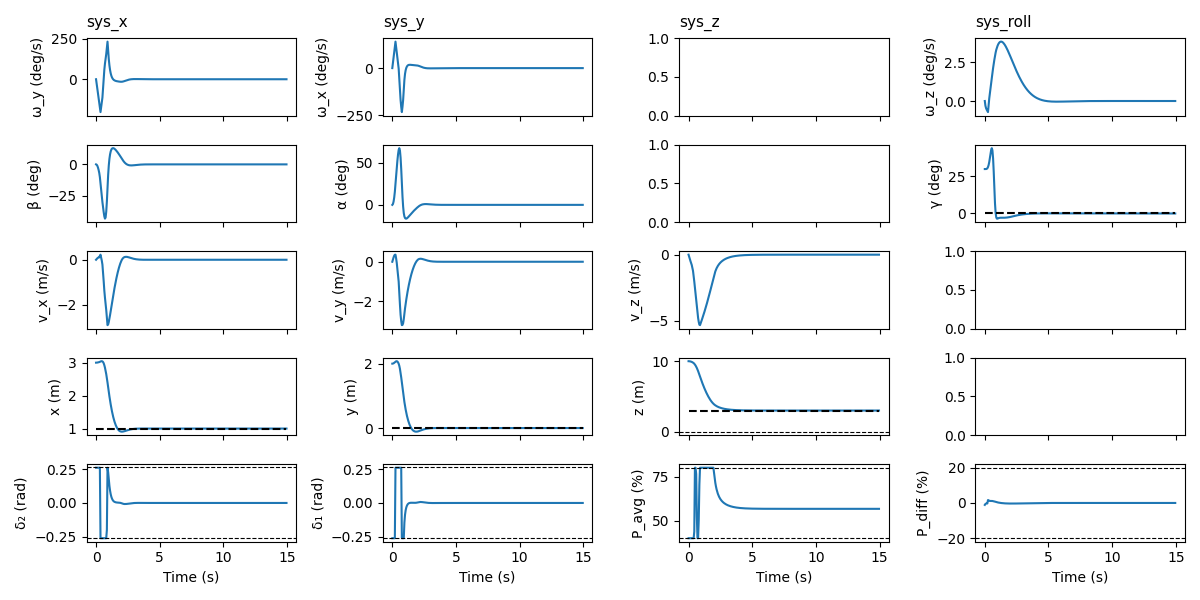

In [5]:
vis.animate(t_cl[:-1], x_cl[:,:-1], u_cl, T_ol=t_ol[...,:-1], X_ol=x_ol, U_ol=u_ol)
plot_static_states_inputs(t_cl[:-1], x_cl[:,:-1], u_cl, xs)

## 6. Comparison with linear MPC approaches
Compared to the linear MPC controllers developped in Part 6, the NMPC controller:
* handles strong nonlinearities naturally,
* does not require model decomposition or tube tightening,
* achieves faster settling and better performance far from equilibrium.

However, this comes at the cost of increased computational complexity and reliance on solver convergence.